In [1]:
1+1

2

In [7]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments') ,
    ('order_items.csv', 'order_items') # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='123',
    database='ecommerce1'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/Nidhi/OneDrive/Desktop/ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for index, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [13]:
import pandas as pd
import mysql.connector
import os
import matplotlib.pyplot as plt
import seaborn as sns

db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "123",
                            database = "ecommerce1")
cur = db.cursor()

# List all unique cities where customers are located.

In [62]:
query = """ select distinct customer_city from customers"""

cur.execute(query)

data = cur.fetchall()

data

[('franca',),
 ('sao bernardo do campo',),
 ('sao paulo',),
 ('mogi das cruzes',),
 ('campinas',),
 ('jaragua do sul',),
 ('timoteo',),
 ('curitiba',),
 ('belo horizonte',),
 ('montes claros',),
 ('rio de janeiro',),
 ('lencois paulista',),
 ('caxias do sul',),
 ('piracicaba',),
 ('guarulhos',),
 ('pacaja',),
 ('florianopolis',),
 ('aparecida de goiania',),
 ('santo andre',),
 ('goiania',),
 ('cachoeiro de itapemirim',),
 ('sao jose dos campos',),
 ('sao roque',),
 ('camacari',),
 ('resende',),
 ('sumare',),
 ('novo hamburgo',),
 ('sao luis',),
 ('sao jose',),
 ('santa barbara',),
 ('ribeirao preto',),
 ('ituiutaba',),
 ('taquarituba',),
 ('sao jose dos pinhais',),
 ('barrinha',),
 ('parati',),
 ('dourados',),
 ('trindade',),
 ('cascavel',),
 ('fortaleza',),
 ('brasilia',),
 ('pelotas',),
 ('porto alegre',),
 ('salto',),
 ('jundiai',),
 ('cacapava',),
 ('sao vicente',),
 ('uberlandia',),
 ('botelhos',),
 ('sao goncalo',),
 ('araucaria',),
 ('nova iguacu',),
 ('areia branca',),
 ('campo

# Count the number of orders placed in 2017.

In [16]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017"""

cur.execute(query)

data = cur.fetchall()

"total orders place in 2017 are", data[0][0]

('total orders place in 2017 are', 45101)

# Find the total sales per category

In [21]:
query = """ select products.product_category category,round( sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data , columns = ["category" , "sales"])
df

,category,sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


# Calculate the percentage of orders that were paid in installments.

In [26]:
query = """ select sum(case when payment_installments >= 1 then 1 
else 0 end)/count(*)*100 from payments"""

cur.execute(query)

data = cur.fetchall()
"the percentage of orders that were paid in installments is ", data[0][0]

('the percentage of orders that were paid in installments is ',
 Decimal('99.9981'))

# Count the number of customers from each state. 


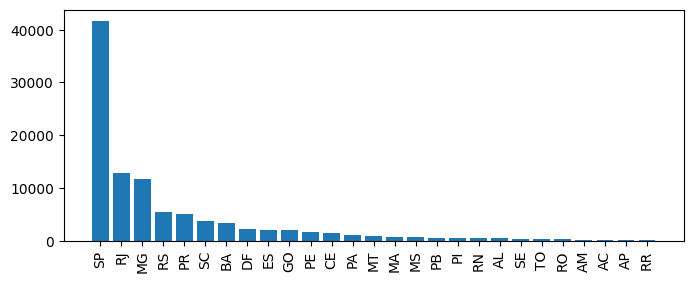

In [31]:
query = """ select customer_state , count(customer_id) 
from customers group by customer_state"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data , columns = ['state' , "customer_count"])
df = df.sort_values(by = "customer_count" , ascending = False)

plt.figure(figsize = (8 ,3))
plt.bar(df["state"] , df["customer_count"])
plt.xticks(rotation = 90)
plt.show()


# Calculate the number of orders per month in 2018.

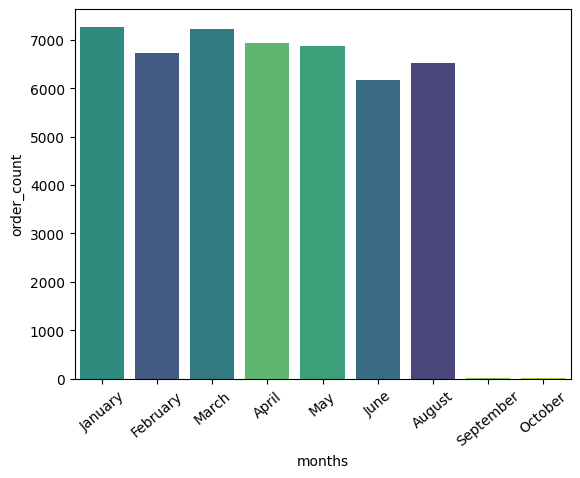

In [49]:
query = """ select monthname(order_purchase_timestamp) months , count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months """


cur.execute(query)

data  = cur.fetchall()
df = pd.DataFrame(data , columns = ["months" , "order_count"])
o = ["January" , "February" , "March" , "April" ,"May" , "June" , "August" ,"September" , "October"]
ax = sns.barplot(x = df["months"], y =  df["order_count"] , data = df , order = o , hue = df["months"] , palette = 'viridis' )
plt.xticks(rotation = 40)
ax.bar_label(ax.containers[0])
plt.show()


#  Find the average number of products per order, grouped by customer city.

In [58]:
query = """
WITH count_per_order AS (
    SELECT 
        orders.order_id, 
        orders.customer_id, 
        COUNT(order_items.order_id) AS oc
    FROM orders
    JOIN order_items ON orders.order_id = order_items.order_id
    GROUP BY orders.order_id, orders.customer_id
)

SELECT 
    customers.customer_city,
    AVG(oc) AS average_orders
FROM customers
JOIN count_per_order ON customers.customer_id = count_per_order.customer_id
GROUP BY customers.customer_city
ORDER BY average_orders DESC;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df.head(10)

,0,1
0,padre carvalho,7.0000
1,celso ramos,6.5000
2,datas,6.0000
3,candido godoi,6.0000
4,matias olimpio,5.0000
5,cidelandia,4.0000
6,picarra,4.0000
7,morro de sao paulo,4.0000
8,teixeira soares,4.0000
9,curralinho,4.0000


# Identify the correlation between product price and the number of times a product has been purchased.

In [60]:
query = """select products.product_category,
count(order_items.product_id),
avg(order_items.price)
from  products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "order_count" , "price"])
df.head(10)


,Category,order_count,price
0,HEALTH BEAUTY,9670,130.163531
1,sport leisure,8641,114.344285
2,Cool Stuff,3796,167.357969
3,computer accessories,7827,116.513903
4,Watches present,5991,201.135984
5,housewares,6964,90.788148
6,electronics,2767,57.913531
7,None,1603,111.999551
8,toys,4117,117.548361
9,bed table bath,11115,93.296327


# Calculate the total revenue generated by each seller, and rank them by revenue.

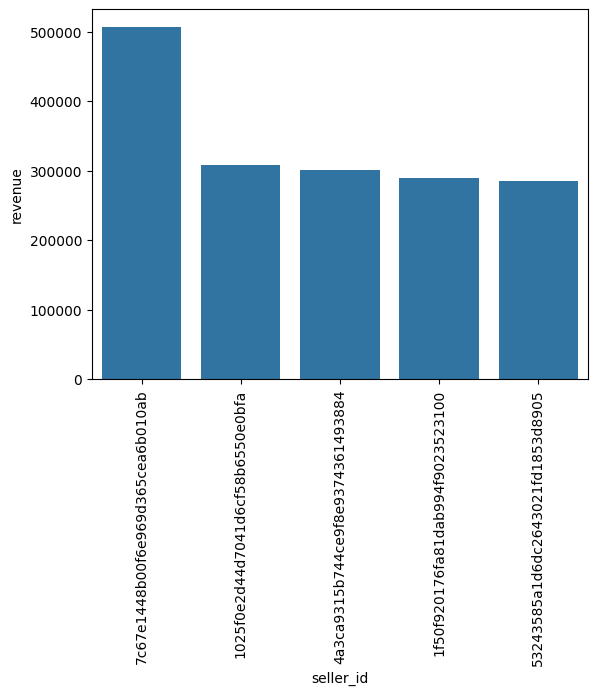

In [72]:
query = """
SELECT *, DENSE_RANK() OVER (ORDER BY revenue DESC) AS rn  
FROM (
    SELECT 
        order_items.seller_id, 
        SUM(payments.payment_value) AS revenue
    FROM order_items 
    JOIN payments ON order_items.order_id = payments.order_id
    GROUP BY order_items.seller_id
) AS a;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data , columns = ["seller_id" ,"revenue" , "rank" ])
df = df.head(5)
sns.barplot(x= "seller_id" , y = "revenue" ,data = df)
plt.xticks(rotation = 90)
plt.show()


# Calculate the moving average of order values for each customer over their order history.

In [73]:
query = """select customer_id  , order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from 
(select orders.customer_id , orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


# Calculate the cumulative sales per month for each year.

In [74]:
query = """ select years, months , sum(payment)
over(order by years , months) cumulative_sales from
(select year(orders.order_purchase_timestamp) as years,
monthname(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years , months) as a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2
0,2016,December,19.62
1,2016,October,59110.10
2,2016,September,59362.34
3,2017,April,477150.37
4,2017,August,1151546.69
5,2017,December,2029948.17
6,2017,February,2321856.18
7,2017,January,2460344.22
8,2017,July,3052727.14
9,2017,June,3564003.52


# Calculate the year-over-year growth rate of total sales.

In [87]:
query = """
WITH a AS (
    SELECT 
        YEAR(orders.order_purchase_timestamp) AS years,
        ROUND(SUM(payments.payment_value), 2) AS payment 
    FROM orders 
    JOIN payments ON orders.order_id = payments.order_id
    GROUP BY years
)
SELECT 
    years, 
    ROUND(((payment - LAG(payment, 1) OVER (ORDER BY years)) / 
           LAG(payment, 1) OVER (ORDER BY years)) * 100, 2) AS yoy_growth_percent
FROM a;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["year", "yoy % growth"])
df

,year,yoy % growth
0,2016,NaN
1,2017,12112.7
2,2018,20.0
